In [2]:
# Load modules
import os
import pandas as pd
import requests
import json
import csv
import time
from dateutil.relativedelta import relativedelta
import datetime as dt
from psaw import PushshiftAPI # https://github.com/dmarx/psaw
from glob import glob


# Submissions

In [3]:
# Load in data
df_subs = pd.read_csv("data/processed/submissions/TheRedPill-submissions-2020-06-01.csv")


In [4]:
# Clean up (drop text and old index column, make utc to date time)
df_subs = df_subs.drop(['Unnamed: 0','selftext'], axis = 1)
df_subs['created_date'] = pd.to_datetime(df_subs['created_utc'], unit = "s").dt.date 

## Quick stats

In [5]:
# Quick stats
num_posts = len(df_subs)
earliest_post = min(df_subs['created_date'])
latest_post = max(df_subs['created_date'])

In [6]:
print("# of posts: "+ str(num_posts))
print("earliest post: " + str(earliest_post))
print("latest post collected: " + str(latest_post))

# of posts: 112211
earliest post: 2012-10-25
latest post collected: 2020-05-16


## Authors

In [7]:
# Looking at authors
top25_authors = df_subs.author.value_counts().nlargest(25)
top25_authors

unique_authors = set(df_subs.author)
len(unique_authors)





33984

In [99]:
# Get cumsum to see who's contributing
df_authors = pd.DataFrame(df_subs.author.value_counts().sort_values())
df_authors.index.name = 'author_name'
df_authors.reset_index(inplace=True)
df_authors['cum_sum'] = df_authors['author'].cumsum()
df_authors['cum_perc'] = df_authors['cum_sum']/df_authors['author'].sum()

# Deleted prevalence
deleted_count = df_authors['author'][df_authors['author_name'] == "[deleted]"].to_numpy()
deleted_perc = deleted_count/len(df_subs)                                            
deleted_perc = round(deleted_perc[0], 2)                                             




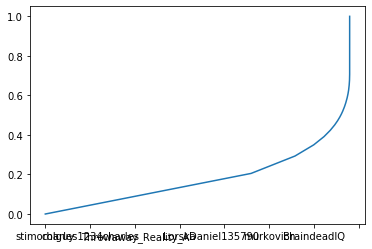

In [29]:
top_contributors = df_authors[df_authors['cum_perc'] > 0.5]


In [103]:
print("this many users make up 50% of posts: "\
      + str(len(df_authors[df_authors['cum_perc'] > 0.5])))
print("this many users make up 40% of posts: "+ str(len(df_authors[df_authors['cum_perc'] > 0.60])))
print("deleted posts are this % of all posts: " + str(round(deleted_perc*100,2)))




this many users make up 50% of posts: 989
this many users make up 40% of posts: 220
deleted posts are this % of all posts: 29.0


## Coverage

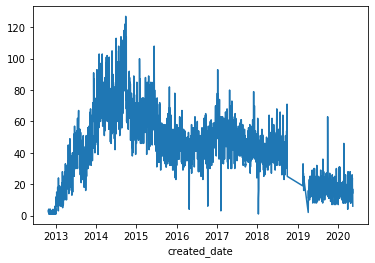

In [142]:
import matplotlib.pyplot as plt

# Plot submissions
plot_submissions = df_subs.groupby('created_date').id.count().plot()
plt.plot()
plt.savefig('trp_posts.png', bbox_inches='tight')

In [119]:
# Explore to see what happend end of 2018
grouped_by_date = pd.DataFrame(df_subs.groupby('created_date').id.count())
grouped_by_date.index.name = 'date'
grouped_by_date.reset_index(inplace = True)
grouped_by_date = grouped_by_date.rename(columns={"id": "count"})

In [112]:
# See if there are dates where there were no posts
from datetime import date, timedelta

d = grouped_by_date['date'].tolist()
date_set = set(min(grouped_by_date['date']) + timedelta(x) for x in range((max(grouped_by_date['date']) - min(grouped_by_date['date'])).days))
missing_dates = set(d).difference(set(date_set))
missing_dates
# seems like all dates are in there? double check? t

{datetime.date(2020, 5, 16)}

In [132]:
# Get dates where count = 1 
grouped_by_date.loc[grouped_by_date['count'] == 1, 'date']

3       2012-10-29
7       2012-11-02
8       2012-11-03
9       2012-11-05
10      2012-11-06
12      2012-11-09
13      2012-11-10
14      2012-11-11
16      2012-11-13
18      2012-11-16
23      2012-11-25
24      2012-11-27
25      2012-11-28
27      2012-11-30
28      2012-12-03
30      2012-12-08
31      2012-12-09
32      2012-12-10
35      2012-12-13
36      2012-12-17
41      2012-12-22
42      2012-12-23
44      2012-12-25
48      2012-12-29
51      2013-01-01
1887    2018-01-11
Name: date, dtype: object

In [131]:
grouped_by_date.loc[grouped_by_date['count'] == 1, 'date']

3       2012-10-29
7       2012-11-02
8       2012-11-03
9       2012-11-05
10      2012-11-06
12      2012-11-09
13      2012-11-10
14      2012-11-11
16      2012-11-13
18      2012-11-16
23      2012-11-25
24      2012-11-27
25      2012-11-28
27      2012-11-30
28      2012-12-03
30      2012-12-08
31      2012-12-09
32      2012-12-10
35      2012-12-13
36      2012-12-17
41      2012-12-22
42      2012-12-23
44      2012-12-25
48      2012-12-29
51      2013-01-01
1887    2018-01-11
Name: date, dtype: object

In [147]:
import requests

url = "https://api.pushshift.io/reddit/search/submission"

# Get before feb 2019 and after june 2018 (eyeballing from graph)
requests.get(url, params = {"subreddit": "TheRedPill", "size": 0, "aggs" : "subreddit", "before": 1548979200, "after": 1538179200}).json()["aggs"]
# 62 posts from Sept 29 2018 to Feb 2019 -- so something with reddit was happening here
# is there a way to look manually?


{'subreddit': [{'doc_count': 62, 'key': 'TheRedPill'}]}

# Comments

In [149]:
# Load in data
df_comments = pd.read_csv("data/processed/comments/TheRedPill-comments-2020-06-01.csv")


In [150]:
# Clean up
df_comments = df_comments.drop(['Unnamed: 0'], axis = 1)
df_comments['created_date'] = pd.to_datetime(df_comments['created_utc'], unit = "s").dt.date 

In [155]:
df_comments.sort_values(['created_date'])


,id,author,created_utc,author_flair_text,score,parent_id,subreddit,created_date
1392514,c6s1r5c,pk_atheist,1351258328,NaN,1,t1_c6rxsvv,TheRedPill,2012-10-26
1392512,c6s3z2k,pk_atheist,1351267385,NaN,2,t1_c6s3vsb,TheRedPill,2012-10-26
1392511,c6s47b5,squarehouse,1351268206,NaN,2,t1_c6s3z2k,TheRedPill,2012-10-26
1392510,c6s4c3b,pk_atheist,1351268678,NaN,2,t1_c6s47b5,TheRedPill,2012-10-26
1392509,c6s4ott,squarehouse,1351269922,NaN,1,t1_c6s4c3b,TheRedPill,2012-10-26
...,...,...,...,...,...,...,...,...
2787661,fs9lmlj,0ggles,1590804705,NaN,2,t3_gt3is4,TheRedPill,2020-05-30
2787660,fs9lug0,AboveAll2017,1590804841,NaN,3,t1_fs9741a,TheRedPill,2020-05-30
2787659,fs9mfv9,_do_not_read_this_,1590805212,NaN,1,t1_fs92rhv,TheRedPill,2020-05-30
2787685,fs9godo,mikrodizels,1590801686,NaN,2,t3_gt3is4,TheRedPill,2020-05-30


In [156]:
# Quick stats
num_comments = len(df_comments)
earliest_comments = min(df_comments['created_date'])
latest_comment = max(df_comments['created_date'])

In [160]:
print("# of comments: "+ str(num_comments))
print("earliest comment: " + str(earliest_comments))
print("latest comment collected: " + str(latest_comment))

# of posts: 3027516
earliest post: 2012-10-26
latest post collected: 2020-05-30


## Authors

In [162]:
# Looking at authors
top25_authors = df_comments.author.value_counts().nlargest(25)
top25_authors

unique_authors = set(df_comments.author)
len(unique_authors)

115486

In [184]:
# Get cumsum to see who's contributing
df_authors = pd.DataFrame(df_comments.author.value_counts().sort_values())

# Make index its own column
df_authors.index.name = 'author_name'
df_authors.reset_index(inplace = True)

# Rename column to count 
df_authors = df_authors.rename(columns={"author": "count"})
df_authors = df_authors.sort_values(['count'])
df_authors['cum_sum'] = df_authors['count'].cumsum()
df_authors['cum_perc'] = df_authors['cum_sum']/df_authors['count'].sum()

# Get count of deleted comments
deleted_comments = df_authors['count'][df_authors['author_name'] == "[deleted]"].to_numpy()[0]
perc_deleted = (deleted_comments/num_comments)*100

In [187]:
# Top 50% of commenters
top_contributors = df_authors[df_authors['cum_perc'] > 0.5]
len(top_contributors)

1060

In [191]:
# Top 40% of commenters
len(df_authors[df_authors['cum_perc'] > 0.6])

# Top 30% of commenters
len(df_authors[df_authors['cum_perc'] > 0.7])

93

## Coverage

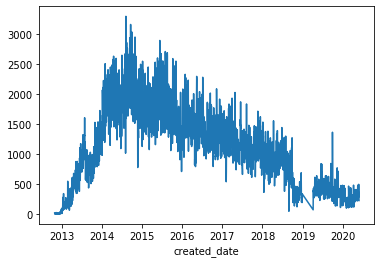

In [192]:
import matplotlib.pyplot as plt

# Plot submissions
plot_submissions = df_comments.groupby('created_date').id.count().plot()
plt.plot()
plt.savefig('trp_comments.png', bbox_inches='tight')

In [ ]:
# from visual analysis of plot, seem to be a 
# hole in early 2019, though this doesn't seem to be same hole seen in submissions